In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense , Dropout
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from sklearn.model_selection import train_test_split


In [2]:
SEQUENCE_LENGTH = 40
FEATURES = 51
batch_size = 32

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout,InputLayer, BatchNormalization, GlobalAveragePooling2D 
from keras import models, layers

## Dataset Pipeline

In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
#------------------- Here the Overlapping Applies --------------------------#
def read_data_from_folder(folder_path, sequence_length=20):
    class_labels = os.listdir(folder_path)
    sequences = []
    labels = []
    for label_num_temp, person_folder in enumerate(class_labels):
        print(f"{label_num_temp} Running for person {person_folder}")
        person_folder_path = os.path.join(folder_path, person_folder)
        if not os.path.isdir(person_folder_path):
            continue

        for csv_file in os.listdir(person_folder_path):
            if not csv_file.endswith('.csv'):
                continue

            csv_file_path = os.path.join(person_folder_path, csv_file)
            df = pd.read_csv(csv_file_path)
            num_sequences = len(df) - sequence_length + 1
            # print(f"num_sequences: {num_sequences}, sequence_length: {sequence_length}, len(df): {len(df)}")
            for i in range(num_sequences):
                sequence = df.iloc[i:i + sequence_length].values
                #First dimension should be features and second should be time
                # print(sequence.shape)
                sequences.append(sequence)
                labels.append(label_num_temp)  # Assuming the person folder name is the label
        

    return sequences, labels, class_labels

train_folder_path = 'D:\\FYP\\Gait3D\\csv_ten'

# Read data from the train folder
sequences, labels, class_labels = read_data_from_folder(train_folder_path, sequence_length=SEQUENCE_LENGTH)


0 Running for person 0000
1 Running for person 0001
2 Running for person 0002
3 Running for person 0003
4 Running for person 0004
5 Running for person 0005
6 Running for person 0006
7 Running for person 0007
8 Running for person 0008
9 Running for person 0009
10 Running for person 0010
11 Running for person 0011
12 Running for person 0012
13 Running for person 0013
14 Running for person 0014
15 Running for person 0015
16 Running for person 0016
17 Running for person 0017
18 Running for person 0018
19 Running for person 0019
20 Running for person 0020


In [5]:
print(len(sequences))
print(len(labels))
print(len(sequences))
# We have taken the 2000 sequences from the total of 2291652 sequences just to see if the model is training or not.


23314
23314
23314


In [6]:

new_sequences = sequences[:2000]
new_labels = labels[:2000]

In [6]:
print(len(sequences))



23314


In [7]:
# print(np.array(sequences).shape)
print(np.array(labels).shape)
print(len(sequences))
print((np.unique(labels)).shape)
class_vocab = np.unique(labels)
print(np.unique(labels))
print(len(np.unique(labels)))

# print(np.array(sequences).shape)

(23314,)
23314
(21,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
21


In [8]:
import numpy as np

def count_occurrences(arr):
    unique_elements, counts = np.unique(arr, return_counts=True)
    occurrences_dict = dict(zip(unique_elements, counts))
    return occurrences_dict

# Example usage:
labels_array = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2])
occurrences = count_occurrences(labels_array)
print(occurrences)


{0: 6, 1: 6, 2: 9}


In [9]:
# Calculates the number of labels
print(count_occurrences(labels))

{0: 516, 1: 11, 2: 155, 3: 3848, 4: 2582, 5: 331, 6: 1359, 7: 425, 8: 135, 9: 114, 10: 2677, 11: 1348, 12: 320, 13: 11, 14: 219, 15: 298, 16: 41, 17: 231, 18: 1186, 19: 1401, 20: 6106}


In [10]:
from sklearn.model_selection import train_test_split

# Assuming you have 'sequences' and 'labels' as your training data
train_sequences, val_sequences, train_labels, val_labels = train_test_split(
    sequences, labels, test_size=0.2, random_state=42) 

In [11]:
def data_generator(sequences, labels, batch_size=32):
    num_samples = len(sequences)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for batch_start in range(0, num_samples, batch_size):
            batch_indices = indices[batch_start:batch_start + batch_size]
            batch_sequences = [sequences[i] for i in batch_indices]
            batch_labels = [labels[i] for i in batch_indices]
            yield np.stack(batch_sequences), np.array(batch_labels)


def create_dataset_generator(sequences, labels, batch_size=32, shuffle_buffer_size=1000):
    generator = data_generator(sequences, labels, batch_size=batch_size)
    dataset = tf.data.Dataset.from_generator(
        lambda: generator,
        output_signature=(
            tf.TensorSpec(shape=(None, SEQUENCE_LENGTH, FEATURES), dtype=tf.float64),
            tf.TensorSpec(shape=(None,), dtype=tf.int64)
        )
    )
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Enable autotune for performance optimization
    return dataset


In [14]:
print(len(class_labels))
num_classes = len(class_labels)
print(class_labels)

21
['0000', '0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020']


In [15]:
# Train the model using the data generator
batch_size = 32  # You can adjust this value based on your system's memory capacity
train_dataset = create_dataset_generator(train_sequences, train_labels, batch_size=batch_size)
validation_dataset = create_dataset_generator(val_sequences, val_labels, batch_size=batch_size)

In [19]:
for batch_sequences, batch_labels in train_dataset.take(1):
    print("Batch sequences shape:", batch_sequences.shape)
    print("Batch labels shape:", batch_labels.shape)
    print("Batch sequences:", batch_sequences[0].numpy())
    print("Batch labels:", batch_labels[0].numpy())
    import numpy as np
print("For the Validation Dataset")
for batch_sequences, batch_labels in validation_dataset.take(1):
    print("Batch sequences shape:", batch_sequences.shape)
    print("Batch labels shape:", batch_labels.shape)
    print("Batch sequences:", batch_sequences[0].numpy())
    print("Batch labels:", batch_labels[0].numpy())
    import numpy as np

    # Assuming you have batch_sequences and batch_labels already defined

    # Save batch_sequences to a CSV file
    # np.savetxt('../DUMP/batch_sequences.csv', batch_sequences[0])

    # Save batch_labels to a CSV file
    # np.savetxt('../DUMP/batch_labels.txt', batch_labels[0])
    print("Batch sequences:", batch_sequences[0].numpy())
    print("Batch labels:", batch_labels[0].numpy())


Batch sequences shape: (32, 40, 51)
Batch labels shape: (32,)
Batch sequences: [[ 85.16699     64.8291       0.9563661  ...  36.631836   290.1709
    0.9243889 ]
 [ 97.84766     67.93359      0.9638251  ...  43.35547    296.80078
    0.89950806]
 [ 96.009766    63.26367      0.9477394  ...  45.970703   288.43945
    0.8739742 ]
 ...
 [ 67.637695    48.56543      0.92799354 ...  92.45215    282.53027
    0.8422748 ]
 [ 65.78418     44.276367     0.9876606  ...  93.674805   270.8877
    0.75337774]
 [ 68.637695    48.56543      0.9744057  ...  96.99707    271.8955
    0.83553207]]
Batch labels: 2549
For the Validation Dataset
Batch sequences shape: (32, 40, 51)
Batch labels shape: (32,)
Batch sequences: [[ 3.88857400e+01  8.42958900e+01  9.32233040e-01 ...  4.29580040e+01
   3.32704100e+02  3.99575530e-01]
 [ 5.06015660e+01  8.24765700e+01  9.11217000e-01 ...  1.10367190e+02
   3.33492200e+02  5.81138250e-01]
 [ 4.89111330e+01  8.30830100e+01  9.04495100e-01 ...  1.01088870e+02
   3.3193

In [14]:
def simple_lstm( sequence_length , features   , num_classes):
    model = Sequential()
    model.add(LSTM(64, input_shape=(  sequence_length , features ), return_sequences=True)) 
    model.add(Dropout(0.4)) 
    model.add(LSTM(64))  # A second LSTM layer without returning sequences
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))  # num_classes = number of unique labels
    return model


In [16]:
def update_simple_lstm( sequence_length , features   , num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=(  sequence_length , features ), return_sequences=True)) 
    model.add(Dropout(0.4)) 
    model.add(LSTM(64))  # A second LSTM layer without returning sequences
    model.add(Dropout(0.2))
    model.add(Dense(16 , activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # num_classes = number of unique labels
    return model


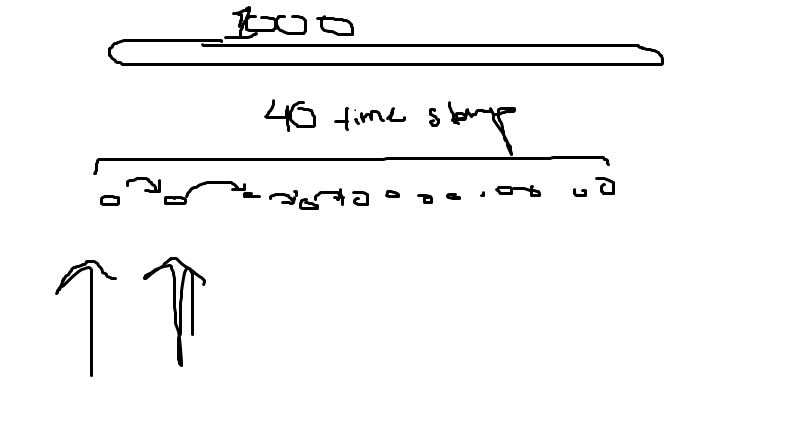

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense

def combined_conv_lstm(sequence_length , features, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(sequence_length , features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # LSTM layers for sequence modeling
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(64))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))  # num_classes = number of unique labels

    return model


In [105]:
import tensorflow as tf
from tensorflow.keras.layers import Add , Layer , Input, Dense, Dropout,Embedding, LayerNormalization, MultiHeadAttention, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

class SequenceEncoder(Layer):
    def __init__(self ,sequence_length, features):
        super(SequenceEncoder, self).__init__()
        self.sequence_length = sequence_length
        self.features = features
        self.embedding_layer = Embedding(input_dim = self.sequence_length, output_dim = self.features)
    def call(self , x ,training = True):
        embedding_input = tf.range(0, limit = self.sequence_length, delta =1 )
        embedding_output = self.embedding_layer(embedding_input)
        x = x + embedding_output
        print(x.shape)
        return x

sample_input = tf.random.uniform(shape = (1, 20, 51))
sequence_encoder = SequenceEncoder(sequence_length = 20, features = 51)
sampleoutput = sequence_encoder(sample_input)
print(sampleoutput.shape)

(1, 20, 51)
(1, 20, 51)


In [106]:
class TransformerEncoder(Layer):
    # key_dims is same as of the Hidden Units
    def __init__(self , H_HEADS , features):
        super().__init__()

        self.norm = LayerNormalization()
        # Key dimensions determine how many feature each frame/patche will be
        # This can be understand by the working of MultiHead Attention Layer  
        self.multi_head_attention = MultiHeadAttention(num_heads=H_HEADS , key_dim=features) 
        self.dense_1 = Dense(units=features , activation=tf.nn.gelu)
        self.dense_2 = Dense(units=features , activation=tf.nn.gelu)

    def call(self , input ,  training = True):
        # --------- This all logic is from the official tranformer paper ------------  #
        x = self.norm(input)
        x = self.multi_head_attention(x , x)  # We have to place the query adn the values 
        x_1 = Add()([input , x])
        x_2 = self.norm(x_1)
        x_2 = self.dense_1(x_2)
        x_2 = self.dense_2(x_2)
        output = Add()([x_1 , x_2])
        print(output.shape)
        return output


sample_input = tf.random.uniform(shape = (1, 20, 51))
transformer_encoder = TransformerEncoder(H_HEADS = 20, features = 51)
sampleoutput = transformer_encoder(sample_input)
print(sampleoutput.shape)

(1, 20, 51)
(1, 20, 51)


In [107]:

# Define the Visual Transformer model
class VitModel(Model):
    def __init__(self , N_Trans_Encoder  , sequence_length  , feature , N_HEADS ,N_CLASSES): 
        super(VitModel , self).__init__(name = "Vision_Transformer")
        self.tranformer_layers = N_Trans_Encoder
        self.sequence_encoder = SequenceEncoder(sequence_length , feature)
        self.transformer_encoder = [TransformerEncoder(N_HEADS , feature) for _ in range(N_Trans_Encoder) ]
        self.dense_1 = Dense(units=feature , activation=tf.nn.gelu)
        self.dense_2 = Dense(units=feature , activation=tf.nn.gelu)
        self.dense_3 = Dense(units=N_CLASSES , activation='softmax')
    def call(self , x , training = True):
        x = self.sequence_encoder(x)
        for i in range(self.tranformer_layers):
            x = self.transformer_encoder[i](x)
        x = Flatten()(x)
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        print(x.shape)
        return x
vit_model =  VitModel(N_Trans_Encoder = 2 ,sequence_length= SEQUENCE_LENGTH , feature = FEATURES , N_HEADS = 2 , N_CLASSES = num_classes)
# input_of_model = Input(shape=(SEQUENCE_LENGTH , FEATURES))
# output_of_model = vit_model(input_of_model)

vit_model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy' , metrics=['accuracy'])
vit_model.build(input_shape=(None, SEQUENCE_LENGTH, FEATURES))  # Build the model
vit_model.summary()

(None, 40, 51)
(None, 40, 51)
(None, 40, 51)
(None, 201)
Model: "Vision_Transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequence_encoder_27 (Sequen  multiple                 2040      
 ceEncoder)                                                      
                                                                 
 transformer_encoder_33 (Tra  multiple                 26571     
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_34 (Tra  multiple                 26571     
 nsformerEncoder)                                                
                                                                 
 dense_115 (Dense)           multiple                  104091    
                                                                 
 dense_116 (Dense)           multiple                  26

In [108]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def on_batch_end(self, batch, logs=None):
#         print("Batch End: Available keys in logs =", list(logs.keys()))

vit_model.fit(train_dataset, epochs=3, steps_per_epoch=steps_per_epoch, verbose=1)


Epoch 1/3
(None, 40, 51)
(None, 40, 51)
(None, 40, 51)
(None, 201)
(None, 40, 51)
(None, 40, 51)
(None, 40, 51)
(None, 201)
6780/6780 [==============================] - 128s 18ms/step - loss: 4.7066 - accuracy: 0.0658
Epoch 2/3
6780/6780 [==============================] - 139s 20ms/step - loss: 4.5561 - accuracy: 0.0673
Epoch 3/3
6780/6780 [==============================] - 118s 17ms/step - loss: 4.5535 - accuracy: 0.0674


In [ ]:

# Define input shape and number of classes
input_shape = (40 , 51)
model_update = update_visual_transformer(input_shape, 4)
model_update.summary()

In [18]:
print(num_classes)

21


In [20]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [21]:
checkpoint_filepath = 'gait3d_simple_lstm_model_checkpoint/checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [18]:
print(len(sequences))
# We have taken the 2000 sequences from the total of 2291652 sequences just to see if the model is training or not.


60572


In [23]:
    
steps_per_epoch = len(train_sequences) // batch_size
# steps_per_epoch = 362
num_epochs = 100  # You can adjust this value based on your training requirements
# history = model.fit(train_dataset ,steps_per_epoch=steps_per_epoch , validation_data=validation_dataset ,  epochs=num_epochs, verbose = 1)
history = model.fit( train_dataset  , steps_per_epoch=steps_per_epoch,  epochs=num_epochs, verbose = 1 )

Epoch 1/100


582/582 [==============================] - 12s 18ms/step - loss: 1.7788 - accuracy: 0.4506
Epoch 2/100
582/582 [==============================] - 10s 18ms/step - loss: 1.6134 - accuracy: 0.4980
Epoch 3/100
582/582 [==============================] - 11s 19ms/step - loss: 1.4887 - accuracy: 0.5278
Epoch 4/100
582/582 [==============================] - 13s 22ms/step - loss: 1.3672 - accuracy: 0.5674
Epoch 5/100
582/582 [==============================] - 11s 18ms/step - loss: 1.2814 - accuracy: 0.5895
Epoch 6/100
582/582 [==============================] - 10s 17ms/step - loss: 1.1990 - accuracy: 0.6107
Epoch 7/100
582/582 [==============================] - 10s 17ms/step - loss: 1.1277 - accuracy: 0.6303
Epoch 8/100
582/582 [==============================] - 9s 16ms/step - loss: 1.0666 - accuracy: 0.6517
Epoch 9/100
582/582 [==============================] - 9s 16ms/step - loss: 1.0089 - accuracy: 0.6687
Epoch 10/100
582/582 [==============================] - 9s 16ms/step - loss: 0.9466 - a

In [26]:
model.evaluate(validation_dataset)

  18997/Unknown - 110s 6ms/step - loss: 0.3138 - accuracy: 0.9113

KeyboardInterrupt: 

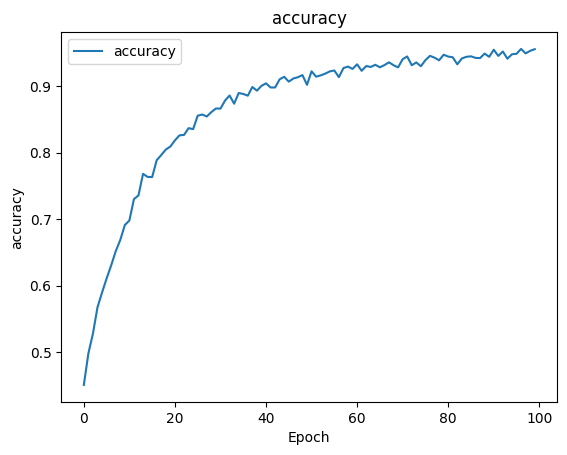

In [27]:
from matplotlib import pyplot as plt

# plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['accuracy'], loc='upper left')

plt.show()

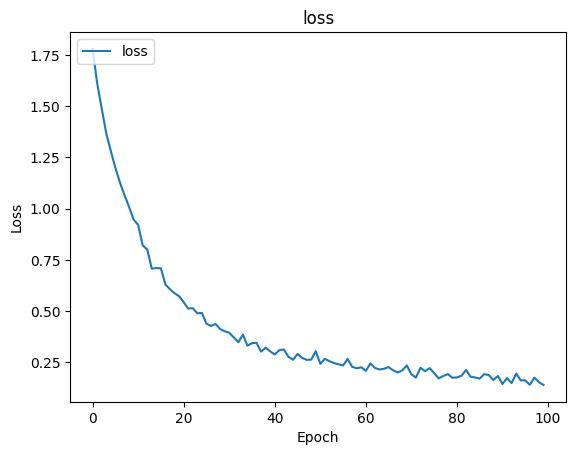

In [28]:
from matplotlib import pyplot as plt

# plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss'], loc='upper left')

plt.show()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 64)            29696     
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 45)                115245    
                                                                 
Total params: 144,941
Trainable params: 144,941
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save_weights('csv_file_half_visual_transformer.h5')

In [ ]:
model.load_weights('csv_file_half_combined_conv_lstm_[1000].h5')

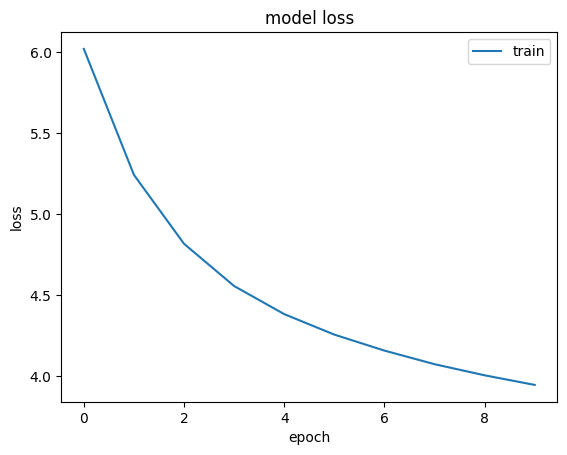

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.legend(['train','validation'],loc='upper right')
plt.legend(['train'],loc='upper right')
plt.show()

In [35]:
import pandas as pd

def read_csv_extract_rows(csv_file_path):
    try:
        # Read the entire CSV file
        df = pd.read_csv(csv_file_path)

        # Extract the data from rows 1 to 30
        data = df.iloc[0:40, :]

        # Optionally, if you want to store the data as a list of lists
        data_list = data.values.tolist()
        data = np.transpose(data)
        return data, data_list

    except FileNotFoundError:
        print(f"File not found: {csv_file_path}")
        return None

# Example usage:
csv_file_path = "D:\\FYP\\Gait3D\\csv_files\\0081\\camid27_videoid3_seq0.csv"
data, data_list = read_csv_extract_rows(csv_file_path)


In [36]:
data = tf.expand_dims(data, axis=0)
print(data.shape)


(1, 51, 40)


In [37]:
print(class_labels[2])

0002


In [38]:

output = model.predict(data)
print(output.shape)
print(tf.argmax(output , axis=-1).numpy()[0])
print(output[0,tf.argmax(output , axis=-1).numpy()[0]])


1/1 [==============================] - 0s 26ms/step
(1, 1000)
602
0.08776522


In [39]:

print(f"The predicted class is {class_labels[(tf.argmax(output , axis=-1)).numpy()[0]]}")

The predicted class is 0602
